# ResNet32

In [ ]:
#@title 1.Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms, utils

import random
import pandas as pd

import sys,os
import fnmatch

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/CS5242')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
#@title 2.Build custom dataset
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

class ImageDataset(Dataset):
    """ Own dataset """

    def __init__(self, img_dir, fruit_category, image_size = 255, class_size = 5000,transform = False):
        """
        Args:
            sketch_dir (string): Directory to all the sketch images.
            realworld_dir (string): Directory to all the real world images.
            fruit_category: list to fruit catogory
            class_size: Num of images in each category
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.fruit_category = fruit_category
        self.class_size = class_size
        self.data_dict = dict(np.load(img_dir))
        self.image_size = image_size
       

        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(image_size),
                                                transforms.ToTensor(),])
                                              # transforms.Normalize( mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.fruit_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.fruit_category[class_index]
        category_idx = int(idx % self.class_size)
        
        label = np.zeros((len(self.fruit_category), 1))
        label[class_index] = 1
        
        image_ary =  self.data_dict[category][category_idx]
        
        sample = {'image': image_ary, 'label': label}
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample
  

In [ ]:
#@title 3.Build ResNet32 model structure
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
'''
Now, that we have created the ResidualBlock, we can build our ResNet.

there are three blocks in the architecture,
To make this block, we create a helper function _make_layer. 
The function adds the layers one by one along with the Residual Block. 
After the blocks, we add the average pooling and the final linear layer.
'''

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 7):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# sketch model 

In [ ]:
#@title  4.1 Quickdraw dataset preparing
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
train_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_train.npz'
train_quickdraw = ImageDataset(train_quickdraw_dir, QURIES, image_size = 64, class_size = 4000,transform = True)
train_loader = DataLoader(train_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

In [ ]:
test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

check batch size images

In [ ]:

def show_batch(X):
    """
    Function to plot grid with several examples of images.
    INPUT:
        X - (numpy array) images dataset
        y - (numpy array) labels for images from X dataset
    """
    fig, axs = plt.subplots(4, 4, figsize=(10,10))
    
    for label_num in range(16):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].permute(1,2,0).numpy()#

        i = label_num // 4
        j = label_num % 4
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
     
       # axs[i,j].set_title(label_dict[y[r_label].item()])
    
    plt.show()


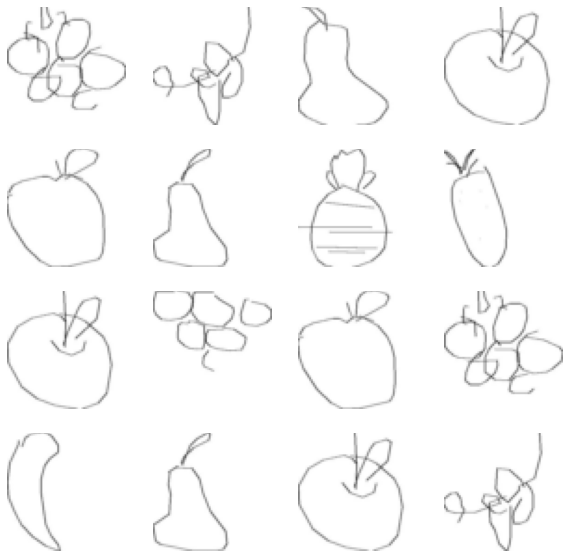

In [ ]:
val_bs = next(iter(val_loader))   
show_batch(val_bs['image'])

In [ ]:
#@title 4.2 ResNet32 hyper-parameter setting
num_classes = 7
num_epochs = 5
batch_size = 128
learning_rate =  0.0001 # 0.0005 0.001
# As we are building the 34 layer variant of ResNet, we need to pass the appropriate number of layers as well
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.01, momentum = 0.9)  
# if use pretrained /retrieve model, please set RESUME = True
RESUME =True



In [ ]:
# record history data
if RESUME:
  checkpoint = torch.load(sys.path[0]+'/resnet32_model_quickdraw_15epoch_with_loss_lr00001.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  train_quickdraw_acc = checkpoint['train_quickdraw_acc']
  train_quickdraw_loss = checkpoint["train_quickdraw_loss"]
  val_quickdraw_acc = checkpoint["val_quickdraw_acc"]
  val_quickdraw_loss= checkpoint["val_quickdraw_loss"]
  
else:
  start_epoch =0
  train_quickdraw_acc = []
  train_quickdraw_loss = []
  val_quickdraw_acc = []
  val_quickdraw_loss= []



In [ ]:
#@title 4.3 ResNet32 sketch model training
import gc

total_step = len(train_loader)

for epoch in range(start_epoch,start_epoch+num_epochs):
    for data in train_loader:  
        # Move tensors to the configured device
        images = data['image'].to(device)
        labels = data['label'].to(device)
        correct_t = 0
        total_t = 0
        # Forward pass
        model.train()
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
        _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
        total_t += labels.size(0)
        correct_t +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    

    train_quickdraw_loss.append(loss.item())
    train_quickdraw_acc.append(correct_t/total_t)
    print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                   .format(epoch+1, start_epoch+num_epochs, loss.item()))
            
    # Validation
    
    with torch.no_grad():
        model.eval()
        correct_v = 0
        total_v = 0
        for data in test_loader:
            images = data['image'].to(device)
            labels = data['label'].to(device)
        

            outputs = model(images)
            loss_v = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
   
            _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
            total_v += labels.size(0)
            correct_v +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
      

            del images, labels, outputs
        val_quickdraw_loss.append(loss_v.item())
        val_quickdraw_acc.append(correct_v/total_v)
        print(f"Validation accuracy: {(correct_v/total_v):.3f}")

print(f"train_acc:{(np.mean([v for v in train_quickdraw_acc])):.3f},val_acc:{(np.mean([v for v in val_quickdraw_acc])):.3f}")


Epoch [16/20], Training Loss: 0.0087
Validation accuracy: 0.874
Epoch [17/20], Training Loss: 0.0084
Validation accuracy: 0.877
Epoch [18/20], Training Loss: 0.0101
Validation accuracy: 0.876
Epoch [19/20], Training Loss: 0.0037
Validation accuracy: 0.875
Epoch [20/20], Training Loss: 0.0032
Validation accuracy: 0.876
train_acc:0.963,val_acc:0.866


Save training model 

In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_quickdraw_acc': train_quickdraw_acc,
            'train_quickdraw_loss': train_quickdraw_loss,
            'val_quickdraw_acc': val_quickdraw_acc,
            'val_quickdraw_loss': val_quickdraw_loss,
            "sketch_features":sketch_features
            }, sys.path[0]+'/resnet32_model_quickdraw_15epoch_with_loss_lr00001.pth')

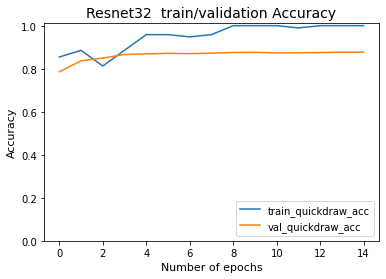

In [ ]:
#@title 4.4 Visulize model performance
import matplotlib.pyplot as plt
# Plot curve
x = [i for i in range(15)]
plt.plot(x, train_quickdraw_acc)
plt.plot(x, val_quickdraw_acc)

plt.legend(['train_quickdraw_acc', 'val_quickdraw_acc'], loc='lower right')
plt.title('Resnet32  train/validation Accuracy',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0)

plt.show()

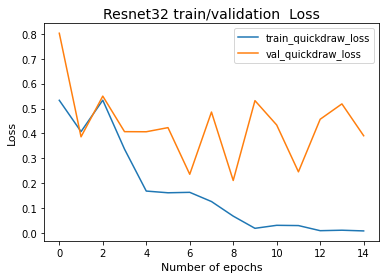

In [ ]:
# Plot curve
x = [i for i in range(15)]
plt.plot(x, train_quickdraw_loss)
plt.plot(x, val_quickdraw_loss)
plt.legend(['train_quickdraw_loss', 'val_quickdraw_loss'], loc='upper right')
plt.title('Resnet32 train/validation  Loss',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)

plt.show() 

random show few images prediction performance

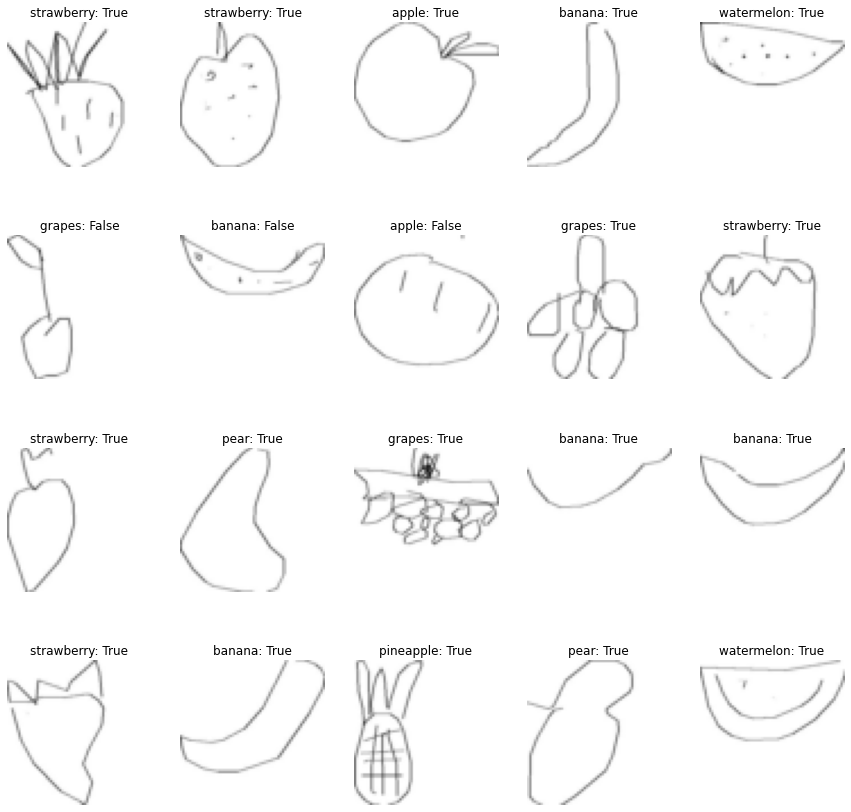

In [ ]:
classes = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
to_pil = transforms.ToPILImage()
test_data = iter(test_loader).next()
images, labels = test_data["image"].cuda(),test_data["label"].cuda()
outputs = model(images)
_, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
predicted = predicted.squeeze()
labels = torch.argmax(labels.squeeze(),dim = 1)
  

fig, axs = plt.subplots(4, 5, figsize=(15,15))
for idx in range(len(images)):
  i = idx // 5
  j = idx % 5

  image = to_pil(images[idx])
 
  res = labels[idx] == predicted[idx]

  axs[i,j].imshow(image) #plot the data
  axs[i,j].axis('off')
  axs[i,j].set_title(classes[predicted[idx]] + ": " + str(res.item()))
plt.show()

# real image model 

In [ ]:
#@title 5.1 Real-world dataset preparing
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes'] 

train_realworld_dir = sys.path[0]+'/compressed_realworld_train.npz'
train_realworld = ImageDataset(train_realworld_dir, QURIES, image_size = 64, class_size = 4000,transform = True)
train_loader = DataLoader(train_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader_realworld = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)

In [ ]:
#@title 5.2 ResNet32 Hyper-parameter setting
num_classes = 7
num_epochs = 15
batch_size = 128

learning_rate = 0.0001
# As we are building the 34 layer variant of ResNet, we need to pass the appropriate number of layers as well
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.007, momentum = 0.9)  
RESUME =False

In [ ]:
# record history data
if RESUME:
  checkpoint = torch.load(sys.path[0]+'/resnet32_model_realworld_15epoch_with_loss_lr0001.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  train_realworld_acc = checkpoint['train_realworld_acc']
  train_realworld_loss = checkpoint["train_realworld_loss"]
  val_realworld_acc = checkpoint["val_realworld_acc"]
  val_realworld_loss= checkpoint["val_realworld_loss"]
 
else:
  start_epoch =0
  train_realworld_acc = []
  train_realworld_loss = []
  val_realworld_acc = []
  val_realworld_loss = []


real world images tarining and validation

In [ ]:
#@title 5.3 real-world model training an validation
import gc
total_step = len(train_loader)

for epoch in range(start_epoch,start_epoch+num_epochs):
    for data in train_loader:  
        # Move tensors to the configured device
        images = data['image'].to(device)
        labels = data['label'].to(device)
        correct_t = 0
        total_t = 0
        # Forward pass
        model.train()
        outputs = model(images)
        loss = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
        _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
        total_t += labels.size(0)
        correct_t +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    
    
    train_realworld_loss.append(loss.item())
    train_realworld_acc.append(correct_t/total_t)
    print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                   .format(epoch+1,start_epoch+num_epochs, loss.item()))
            
    # Validation
    
    with torch.no_grad():
        model.eval()
        correct_v = 0
        total_v = 0
        for data in test_loader_realworld:
            images = data['image'].to(device)
            labels = data['label'].to(device)
        

            outputs = model(images)
            loss_v = criterion(outputs, torch.argmax(labels.squeeze(),dim = 1))
   
            _, predicted = outputs.squeeze().topk(1, dim=1, largest=True, sorted=True)
        
            total_v += labels.size(0)
            correct_v +=  (predicted.squeeze() == torch.argmax(labels.squeeze(),dim = 1)).sum().item()
      
            del images, labels, outputs
        val_realworld_loss.append(loss_v.item())
        val_realworld_acc.append(correct_v/total_v)
        print(f"Validation accuracy: {(correct_v/total_v):.3f}")
       
print(f"train_acc:{(np.mean([v for v in train_realworld_acc])):.3f},val_acc:{(np.mean([v for v in val_realworld_acc])):.3f}") 
    
   

Epoch [1/15], Training Loss: 1.0334
Validation accuracy: 0.735
Epoch [2/15], Training Loss: 0.8899
Validation accuracy: 0.792
Epoch [3/15], Training Loss: 0.7289
Validation accuracy: 0.825
Epoch [4/15], Training Loss: 0.4823
Validation accuracy: 0.846
Epoch [5/15], Training Loss: 0.4944
Validation accuracy: 0.844
Epoch [6/15], Training Loss: 0.2510
Validation accuracy: 0.866
Epoch [7/15], Training Loss: 0.2241
Validation accuracy: 0.877
Epoch [8/15], Training Loss: 0.0893
Validation accuracy: 0.874
Epoch [9/15], Training Loss: 0.0510
Validation accuracy: 0.873
Epoch [10/15], Training Loss: 0.0488
Validation accuracy: 0.870
Epoch [11/15], Training Loss: 0.0172
Validation accuracy: 0.861
Epoch [12/15], Training Loss: 0.0357
Validation accuracy: 0.870
Epoch [13/15], Training Loss: 0.0058
Validation accuracy: 0.867
Epoch [14/15], Training Loss: 0.0118
Validation accuracy: 0.870
Epoch [15/15], Training Loss: 0.0066
Validation accuracy: 0.866
train_acc:0.903,val_acc:0.849


In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_realworld_acc': train_realworld_acc,
            'train_realworld_loss': train_realworld_loss,
            'val_realworld_acc': val_realworld_acc,
            'val_realworld_loss': val_realworld_loss,
   
          
            }, sys.path[0]+'/resnet32_model_realworld_15epoch_with_loss_lr0001.pth')

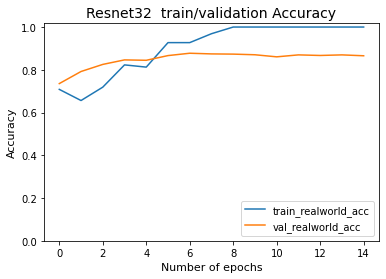

In [ ]:
#@title 5.4 Visulize model performance
import matplotlib.pyplot as plt
# Plot curve
x = [i for i in range(15)]
plt.plot(x, train_realworld_acc)
plt.plot(x, val_realworld_acc)

plt.legend(['train_realworld_acc', 'val_realworld_acc'], loc='lower right')
plt.title('Resnet32  train/validation Accuracy',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.ylim(0)

plt.show()

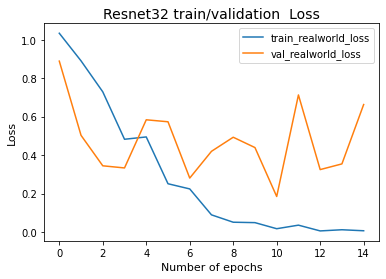

In [ ]:
# Plot curve
x = [i for i in range(15)]
plt.plot(x, train_realworld_loss)
plt.plot(x, val_realworld_loss)
plt.legend(['train_realworld_loss', 'val_realworld_loss'], loc='upper right')
plt.title('Resnet32 train/validation  Loss',  fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)

plt.show()

# Image feature similarity

In [ ]:
#@title 6.1 Collect real_image and sketch image features
def get_feature(model,feature,test_loader):
  with torch.no_grad():
    for data in test_loader:
      images = data['image'].to(device)
      labels = data['label'].to(device)
      outputs = model(images)

      labels_sq = torch.argmax(labels.squeeze(),dim = 1).tolist()

      
      for i in range(outputs.shape[0]):
        feature[labels_sq[i]].append(outputs[i])
        
  fea_resize = torch.empty((7000,7))
  for i in range(len(feature)):
    fea_resize[i*1000:1000*(i+1)] = torch.stack(feature[i])
  return fea_resize

In [ ]:
from collections import defaultdict
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

sketch_features = defaultdict(list)
features_real = defaultdict(list)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
num_epochs = 15
batch_size = 128
learning_rate = 0.001  


model_sketch = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

model_real  = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

checkpoint1 = torch.load(sys.path[0]+'/resnet32_model_quickdraw_15epoch_with_loss_lr00001.pth')
model_sketch.load_state_dict(checkpoint1['model_state_dict'])


checkpoint2 = torch.load(sys.path[0]+'/resnet32_model_realworld_15epoch_with_loss_lr0001.pth')
model_real.load_state_dict(checkpoint2['model_state_dict'])



test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader_sketch = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)



test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 64, class_size = 1000,transform = True)
test_loader_real = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)



reshape features:
1. sketch feature: (1,7) * 7000 images
2. real feature: (7*1000)*7    --> matrix M(7000*7)



In [ ]:
fea1 = get_feature(model_sketch,sketch_features,test_loader_sketch)
fea2 = get_feature(model_real,features_real,test_loader_real)

In [ ]:
#@title 6.2 Caculate cos similarity for each sketch image

def cos_similarity(k,fea2,fea1):
  correct = 0
  total = 0
  real_matrix = F.normalize(fea2) 
  for idx, image in enumerate(fea1):
    feature1 = image.reshape(1,-1)
    a = F.normalize(feature1)
    res = F.cosine_similarity(a,real_matrix)
    _,predict = res.topk(k, largest=True, sorted=True)

    correct += sum([idx//1000==i//1000 for i in predict]).item()
    total += k

  print(f"k = {k}, predict accuracy is {(correct/total):.3f}")  
  return (correct/total)


In [ ]:
topk_acc = []
for kk in [1,3,5,10,20]:
  acc = cos_similarity(kk,fea2,fea1)
  topk_acc.append(acc)

k = 1, predict accuracy is 0.776
k = 3, predict accuracy is 0.798
k = 5, predict accuracy is 0.807
k = 10, predict accuracy is 0.818
k = 20, predict accuracy is 0.826


# Archive data

create model data history

In [ ]:
def save_model_history(metrics, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(metrics, file)

def load_model_history(filepath):
    with open(filepath, 'rb') as file:
        metrics = pickle.load(file)
    return metrics

# save_model_history(model_history, './resnet_data.pkl')

# model_history = load_model_history('./resnet_data.pkl')


In [ ]:
import pickle

model_history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],

    # Please save the following metric
    "train_realworld_acc": [],
    "train_quickdraw_acc": [],
    "val_realworld_acc": [],
    "val_quickdraw_acc": [],
    "train_realworld_loss": [],
    "train_quickdraw_loss": [],
    "val_realworld_loss": [],
    "val_quickdraw_loss": [],
    "k_choice": [], # [1,3,5,10,20]
    "topk_acc": []
}

In [ ]:
# best quickdraw model data
checkpoint_quickdraw = torch.load(sys.path[0]+'/resnet32_model_quickdraw_15epoch_with_loss_lr00001.pth')

train_quickdraw_acc = checkpoint_quickdraw['train_quickdraw_acc']
train_quickdraw_loss = checkpoint_quickdraw["train_quickdraw_loss"]
val_quickdraw_acc = checkpoint_quickdraw["val_quickdraw_acc"]
val_quickdraw_loss= checkpoint_quickdraw["val_quickdraw_loss"]

# get best realworld model data
checkpoint_realworld = torch.load(sys.path[0]+'/resnet32_model_realworld_15epoch_with_loss_lr0001.pth')
  
train_realworld_acc = checkpoint_realworld['train_realworld_acc']
train_realworld_loss = checkpoint_realworld["train_realworld_loss"]
val_realworld_acc = checkpoint_realworld["val_realworld_acc"]
val_realworld_loss= checkpoint_realworld["val_realworld_loss"]

In [ ]:
model_history["epoch"] = [i for i in range(15)]
model_history["k_choice"] = [1,3,5,10,20]
model_history["topk_acc"] = topk_acc

model_history["train_quickdraw_loss"] = train_quickdraw_loss
model_history["train_quickdraw_acc"] = train_quickdraw_acc
model_history["val_quickdraw_acc"] = val_quickdraw_acc
model_history["val_quickdraw_loss"] = val_quickdraw_loss

model_history["train_realworld_loss"] = train_realworld_loss
model_history["train_realworld_acc"] = train_realworld_acc
model_history["val_realworld_acc"] = val_realworld_acc
model_history["val_realworld_loss"] = val_realworld_loss

In [ ]:
filepath = "/content/drive/My Drive/Colab Notebooks/CS5242"
save_model_history(model_history, filepath+'/resnet_data_15epoch.pkl')